Normalizing features...
Training SVM on normalized data...
Training Time: 46.21s
Train Accuracy: 86.03% | Test Accuracy: 67.56%

Per-Class Accuracy Breakdown:
Class        | Accuracy  
-------------------------
plane        |  74.10%
car          |  74.00%
bird         |  54.10%
cat          |  52.80%
deer         |  63.90%
dog          |  57.30%
frog         |  77.10%
horse        |  71.20%
ship         |  78.50%
truck        |  72.60%


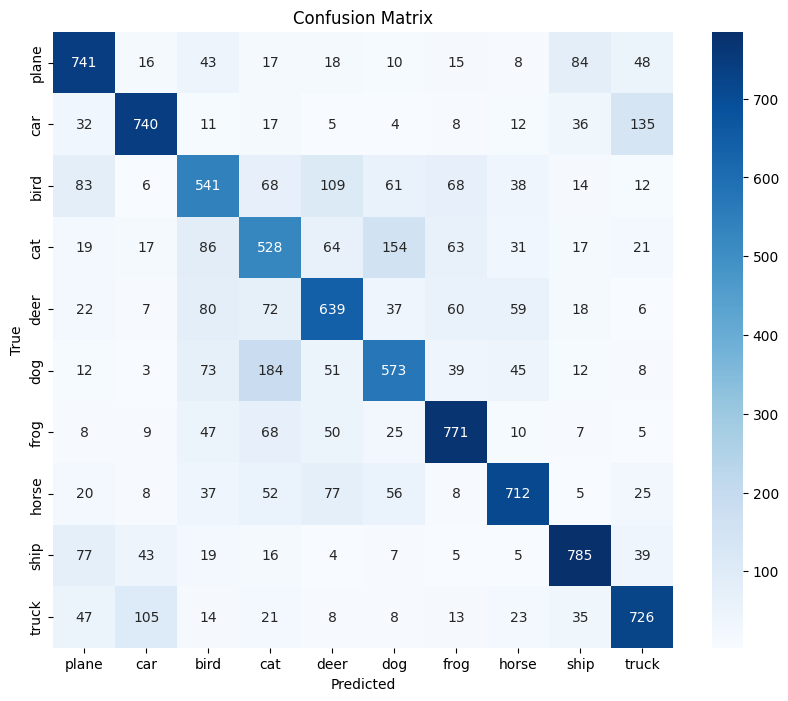

In [1]:
import cudf
from cuml.svm import SVC, LinearSVC
from cuml.decomposition import PCA
from cuml.metrics import accuracy_score, confusion_matrix
from cuml.preprocessing import StandardScaler
import time 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CLASSES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 1. Load Data
def load_data(feat_path, label_path):
    X = cudf.read_csv(feat_path, header=None).astype('float32')
    y = cudf.read_csv(label_path, header=None).astype('int32')
    return X, y.iloc[:, 0]

X_train, y_train = load_data('/kaggle/input/cifar-10-extracted/train_features.csv', 
                             '/kaggle/input/cifar-10-extracted/train_labels.csv')
X_test, y_test = load_data('/kaggle/input/cifar-10-extracted/test_features.csv', 
                           '/kaggle/input/cifar-10-extracted/test_labels.csv')

# 2. Normalize Features
print("Normalizing features...")
scaler = StandardScaler()
# We 'fit' only on training data to avoid data leakage from the test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Train SVM with better hyperparameters
# I increased C to 10.0 to allow for a stricter boundary
print("Training SVM on normalized data...")
model = SVC(kernel='rbf', C=10.0, gamma='scale')
start = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start

# 2. Accuracy Calculation
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Training Time: {train_time:.2f}s")
print(f"Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%")

# 3. Confusion Matrix & Per-Class Accuracy
cm = confusion_matrix(y_test, test_preds).get() # Move to CPU for plotting
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Table Breakdown
print("\nPer-Class Accuracy Breakdown:")
print(f"{'Class':<12} | {'Accuracy':<10}")
print("-" * 25)
class_accs = cm_norm.diagonal()
for i, acc in enumerate(class_accs):
    print(f"{CLASSES[i]:<12} | {acc*100:6.2f}%")

# 4. Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()